# (4): Visibility Fitting

Now that you have had some exposure to the theoretical aspects of how an interferometer works, we can turn toward a more practical application of that information.  In Part (3), you should have internalized that (a) the actual data an interferometer like ALMA records are complex visibiities at a collection of points in the spatial frequency ($u$, $v$) domain; and (b) the creation of an image and analysis of an associated radial surface brightness profile are complicated.  For the latter point, the brightness profile is especially problematic for modeling because of the convolution kernel (the PSF) and the fact that the noise (uncertainties) are ill-defined.  So, here we turn instead to analyzing the visibility data.  First, we load it and package it:

In [114]:
import os, sys, time               # I basically always load these in every code I write.
import numpy as np                 # Numpy is the basic numerics package in Python.
import urllib.request              # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
%matplotlib inline                

# disk target name
disk_name = 'SR4'

# set this to your project directory (or however you like)
working_dir = '/Users/sandrews/Desktop/DSHARP_CPDs/'

# if you don't already have the datafile, download it
if not os.path.exists(working_dir+disk_name+'_continuum.vis.npz'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum.vis.npz'
    print('Downloading VISIBILITY data...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.vis.npz')
    print('...Download complete.')

# load the visibility data
dat = np.load(disk_name+'_continuum.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']

# create a visibility data class and use it to package up the data neatly
class Visibility:
    def __init__(self, vis, u, v, wgt):
        self.vis = vis 
        self.u = u 
        self.v = v 
        self.wgt = wgt
dvis = Visibility(vis, u, v, wgt)

In Part (3), we looked at the visibility data briefly.  But here, we're going to be making the same assumptions we made in Part (2): namely, that the emission is effectively symmetric and one-dimensional (radial) on the sky, with no azimuthal or vertical components aside from those associated with the projection and rotation toward our line of sight.  That means we can do the same kinds of coordinate transformations (translational shift, deprojection, rotation) and azimuthally average the data into a 1-D radial profile of the visibilities.  That can be done with a function like this:  

In [73]:
# define a function to generate a 1-D visibility "profile"
def deproject_vis(data, bins=np.array([0]), incl=0., PA=0., offx=0., offy=0.):
        
    # convert keywords into relevant units
    inclr = np.radians(incl)
    PAr = 0.5 * np.pi - np.radians(PA)
    offx *= -np.pi / (180 * 3600)
    offy *= -np.pi / (180 * 3600)

    # change to a deprojected, rotated coordinate system
    uprime = (data.u * np.cos(PAr) + data.v * np.sin(PAr))
    vprime = (-data.u * np.sin(PAr) + data.v * np.cos(PAr)) * np.cos(inclr)
    rhop = np.sqrt(uprime**2 + vprime**2)

    # phase shifts to account for offsets
    shifts = np.exp(-2 * np.pi * 1.0j * (data.u*-offx + data.v*-offy))
    visp = data.vis * shifts
    realp = visp.real
    imagp = visp.imag
    
    # create a class to return outputs
    class Vis_profile:
        def __init__(self, vis_prof, rho_uv, err_std, err_scat, nperbin):
            self.vis_prof = vis_prof 
            self.rho_uv = rho_uv 
            self.err_std = err_std
            self.err_scat = err_scat
            self.nperbin = nperbin

    # if requested, return a binned (averaged) representation
    if (bins.size > 1):
        avbins = 1e3 * bins       # scale to lambda units (input in klambda)
        bwid = 0.5 * (avbins[1] - avbins[0])
        bvis = np.zeros_like(avbins, dtype='complex')
        berr_std = np.zeros_like(avbins, dtype='complex')
        berr_scat = np.zeros_like(avbins, dtype='complex')
        n_in_bin = np.zeros_like(avbins, dtype='int')
        for ib in np.arange(len(avbins)):
            inb = np.where((rhop >= avbins[ib] - bwid) & (rhop < avbins[ib] + bwid))
            if (len(inb[0]) >= 5):
                bRe, eRemu = np.average(realp[inb], weights=wgt[inb], returned=True)
                eRese = np.std(realp[inb])
                bIm, eImmu = np.average(imagp[inb], weights=wgt[inb], returned=True)
                eImse = np.std(imagp[inb])
                bvis[ib] = bRe + 1j*bIm
                berr_scat[ib] = eRese + 1j*eImse
                berr_std[ib] = 1 / np.sqrt(eRemu) + 1j / np.sqrt(eImmu)
                n_in_bin[ib] = np.size(bRe)
            else:
                bvis[ib] = 0 + 1j*0
                berr_scat[ib] = 0 + 1j*0
                berr_std[ib] = 0 + 1j*0
                n_in_bin[ib] = 0
        parser = np.where(berr_std.real != 0)
        output = Vis_profile(bvis[parser], avbins[parser], berr_std[parser], berr_scat[parser], n_in_bin[parser])
        return output
    
    # if not, returned the unbinned representation
    output = Vis_profile(realp + 1j*imagp, rhop, 1 / np.sqrt(wgt), 1 / np.sqrt(wgt), np.zeros_like(rhop))

    return output

We can now use that function to construct the variations of the (azimuthally-averaged) real and imaginary visibilities as a function of the (deprojected) baseline length of the interferometer.  This is essentially the Fourier Transform of the radial surface brightness profile we constructed in Part (2) (and will revisit below).  

*Note: I have modified the viewing geometry slightly, with some more detailed analysis and consideration of other available data.  We can discuss this.*

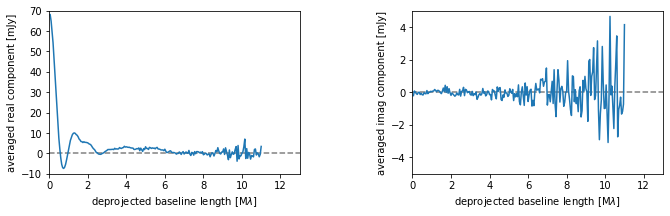

In [115]:
# the geometric parameters
incl, PA = 22., 26.
offRA, offDEC = -0.060, -0.509

# decide on the bins in (u,v)-distance for the profile, in kilo-lambda units
uvbins = np.arange(50, 11050, 50)

# generate the deprojected visibility profile
vp = deproject_vis(dvis, bins=uvbins, incl=incl, PA=PA, offx=offRA, offy=offDEC)

# plots
fig, axs = plt.subplots(ncols=2, figsize=(11,3))
ax = axs[0]
ax.plot([0, 13], [0, 0], '--k', alpha=0.5)
ax.plot(vp.rho_uv * 1e-6, vp.vis_prof.real * 1e3)
ax.set_xlim([0, 13])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 70])
ax.set_ylabel('averaged real component [mJy]')

ax = axs[1]
ax.plot([0, 13], [0, 0], '--k', alpha=0.5)
ax.plot(vp.rho_uv * 1e-6, vp.vis_prof.imag * 1e3)
ax.set_xlim([0, 13])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-5, 5])
ax.set_ylabel('averaged imag component [mJy]')
fig.subplots_adjust(wspace=0.45)

Notice the difference in scales on the y-axes for the real and imaginary components.  And notice how the latter is essentially symmetric about zero (which affirms what we've seen in the image, that there's not a significant asymmetric component to the emission).

Ok, so now we want to develop a simple model designed to "fit" the data (visibilities).  In practice, the model is a parameterized radial surface brightness profile, like the ones you've already experimented with in Part (2).  Except here, we'll take its Fourier Transform.  There are a few pieces to this process.  But first, let's retrieve the "observed" brightness profile you constructed in Part (2).  To do that, you need to re-run the Part (2) notebook with the same geometry parameters adopted here (my apologies).  That generates a file called "SR4_cleanSBr.txt" that stores the profile in an ASCII format that we can use here for some guidance.  Presuming you've done that, load it:

In [116]:
# load the CLEAN surface brightness profile
r, SBr, err_SBr = np.loadtxt(disk_name+'_cleanSBr.txt').T

Now, instead of relying on a numerical FFT (Fast Fourier Transform) for the modeling, we'll be making an approximation that essentially makes the FT of any arbitrary radial brightness profile "analytic".  The idea is to decompose the brightness profile into discrete radial bins (i.e., annuli), where the brightness in each bin is constant (this is effectively like a "pixel" in an image).  This amounts to a linear combination of constant-brightness annuli, each of which has an exact FT in the form of a difference between two Bessel functions (in the 1-D radial domain like our example, this approach is called the "discrete Hankel transform").  By the linearity of the FT, the visibilities are just the sum of these Bessel functions over the annuli.  

The first step is to define the annular bins we'll use to compute brightness profile models on:

In [106]:
# define the radius bins
b = np.arange(0.003, 0.453, 0.003)     # bin outer edges
a = np.roll(b, 1)                      # bin inner edges
rin = 0.1/140.                         # innermost bin's inner edge
a[0] = rin
rbin_centers = 0.5*(a+b)               # bin centers
rbin_edges = rin, b

Note that the bins are spaced by $\sim$3 milliarcseconds, which is roughly 10x smaller than our angular resolution.  Also, the outermost bin ends at 0.45 arcseconds, which is about 50% larger than where the emission disappears into the noise (at about 0.3 arcseconds).  The innermost edge corresponds to a radius of roughly 0.1 AU.  

Now we create a function that defines the surface brightness profile at those (or arbitrary) radial bins.  There is a lot of flexibility in how we do this.  I don't want to worry about it too much, since we'll end up using a different tool to get there.  But for this initial exploration, we'll assume there's an inner core of emission and an outer ring of emission (based on the image's appearance), both of which have Gaussian distributions.  The parameters of each Gaussian are the normalization, mean, and width.  For the normalizations, we'll use their integrated fluxes (obviously this has an analytic value, but because of the discretization it usually makes sense to do the integral numerically).  The core has a mean = 0, so we just fix that.

In [117]:
def SB_model(pars, rbins):
        
    # parse the parameter values
    Fcore = pars[0]      # core component flux in Jy
    sig_core = pars[1]   # standard deviation (width) of core in arcseconds
    Fring = pars[2]      # ring component flux in Jy
    rring = pars[3]      # mean position of ring in arcseconds
    sig_ring = pars[4]   # standard deviation (width) of ring in arcseconds
    
    # compute the core intensity profile
    Inu_core = np.exp(-0.5 * (rbins / sig_core)**2)
    Inu_core *= Fcore / np.trapz(2 * np.pi * rbins * Inu_core, rbins)
    
    # compute the ring intensity profile
    Inu_ring = np.exp(-0.5 * ((rbins - rring) / sig_ring)**2)
    Inu_ring *= Fring / np.trapz(2 * np.pi * rbins * Inu_ring, rbins)
    
    return (Inu_core + Inu_ring)

Now we write a function that performs the discrete Hankel transform for a model brightness profile on a given set of spatial frequency ($u$, $v$)-distances.  The algorithm is bit awkward, and the math perhaps seems unwieldy, but neither is particularly relevant for this project.  If you're interested in knowing more, you can read about the math [here](https://github.com/seanandrews/D3SB/blob/master/notebooks/concepts.ipynb) and the code [here](https://github.com/seanandrews/D3SB/blob/master/notebooks/how%20D3SB%20works.ipynb).

In [120]:
import scipy.special as sfunc

def vis_model(SB, rbins, uvdist):
    
    # deprojected baseline lengths to proper units
    rho = uvdist * np.pi / (180 * 3600)

    # re-orient the array of outer edges for the radius bins
    rin, b = rbins
    rbin = np.concatenate([np.array([rin]), b])

    # compute the matrix of jinc functions (Nvis x Nbins)
    jarg = np.outer(2 * np.pi * rbin, rho)
    jinc_matrix = sfunc.j1(jarg) / jarg

    # re-orient array of (binned) surface brightnesses
    Ibin = np.append(np.concatenate([np.array([0.0]), SB]), 0.)
    II = Ibin - np.roll(Ibin, -1)
    intensity = np.delete(II, SB.size)
    
    # compute the visibilities (a summation of Hankel transforms for each intensity annulus)
    mvis = np.dot(2 * np.pi * rbin**2 * intensity, jinc_matrix)

    return mvis

Now, let's generate an example model and compare it to the visibilities and a (simplified) convolved representation of the surface brightness profile.

In [121]:
# surface brightness model
pars = [0.01, 0.025, 0.06, 0.16, 0.05]
model_Inu = SB_model(pars, rbin_centers)

# 1-D convolution kernel for the brightness profile
from astropy.convolution import Gaussian1DKernel, convolve
sig_beam = np.sqrt(beam_maj * beam_min) / (2 * np.sqrt(2 * np.log(2)))
psf = Gaussian1DKernel(stddev=sig_beam / np.mean(np.diff(rbin_centers[1:])))
Inu_model_conv = convolve(model_Inu, psf, boundary='extend')

# visibility model
model_FT = vis_model(model_Inu, rbin_edges, vp.rho_uv)

And now make some plots to compare the data and model:

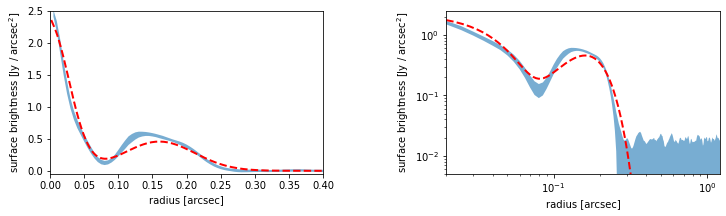

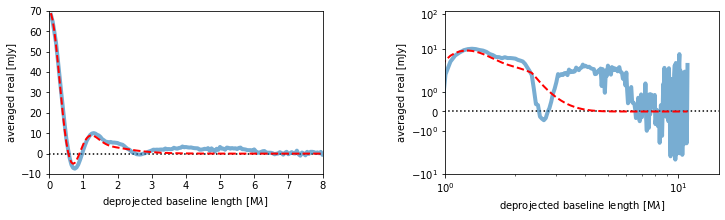

In [124]:
# surface brightness profiles
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

ax = axs[0]
ax.fill_between(r, SBr-err_SBr, SBr+err_SBr, alpha=0.6)
ax.set_xlim([0.0, 0.4])
ax.set_ylim([-0.05, 2.5])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')
ax.plot(rbin_centers, Inu_model_conv, '--r', lw=2)

ax = axs[1]
ax.fill_between(r, SBr-err_SBr, SBr+err_SBr, alpha=0.6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.02, 1.2])
ax.set_ylim([0.005, 2.5])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')
ax.plot(rbin_centers, Inu_model_conv, '--r', lw=2)

fig.subplots_adjust(wspace=0.45)


# visibility profiles
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

ax = axs[0]
ax.plot([0, 15], [0, 0], ':k')
ax.plot(vp.rho_uv * 1e-6, vp.vis_prof.real * 1e3, alpha=0.6, lw=4)
ax.set_xlim([0, 8])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 70])
ax.set_ylabel('averaged real [mJy]')
ax.plot(vp.rho_uv * 1e-6, model_FT * 1e3, '--r', lw=2)

ax = axs[1]
ax.plot([0, 15], [0, 0], ':k')
ax.plot(vp.rho_uv * 1e-6, vp.vis_prof.real * 1e3, alpha=0.6, lw=4)
ax.set_xlim([1, 15])
ax.set_xscale('log')
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 125])
ax.set_yscale('symlog')
ax.set_ylabel('averaged real [mJy]')
ax.plot(vp.rho_uv * 1e-6, model_FT * 1e3, '--r', lw=2)

fig.subplots_adjust(wspace=0.45)

As you tinker here, a couple things to note: (1) Pay attention to the axes in these plots, since I'm showing only parts of things in slightly different units to focus the eye; (2) For the model profile in the top panels, it is important to remember that a convolution by a 1-D Gaussian kernel is a poor representation of what really happens in a 2-D image with the imaging procedures mentioned in the Part 3 notebook.  Don't over-rely on fit quality or emission behavior in the top panels...the goal is a reasonable approximation of the bottom panels!  

**Activities:**

So, once you have experimented with the code above, there is one especially useful thing to work on here:

- The example model defined above does a *pretty* good job explaining the data, but it fails notably in a few areas.  I do not think this is a simple fix where we can change the model parameters to improve the fit quality.  Instead, we probably need to make the model itself more sophisticated.  Think about what we might need to do to improve the match with the data.  I think one "easy" solution might be to add 2 more Gaussians, splitting both the "core" and the "ring" into 2 Gaussians each.  Another option might be to adopt different functional forms (not Gaussians)...but let's discuss that option after you try the 4-Gaussian model.  See if you can tune up the parameters manually to get a better fit to the data.  Even if you can't get it perfectly, the point here is to come up with an appropriate parameterization that is *capable* of describing the data...we'll use a different machinery to find the best model anyway, this is more of a practical exploration so that you understand how changes to the brightness profile affect the visibilities.

In [56]:
# your code here